### Random Forest scratch

In [1]:
import sys
    
sys.path.insert(0, "..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import helper as hlp

from sklearn.ensemble import RandomForestRegressor as RandomForestRegressorR
from sklearn.tree import DecisionTreeRegressor as DecisionTreeRegressorR

from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from pandas.api.types import is_categorical_dtype

In [3]:
# loading data
raw = pd.read_csv("./data/sales.csv", low_memory = False, parse_dates = ["saledate"]);

In [4]:
raw.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# remove skewness
raw["SalePrice"] = np.log(raw["SalePrice"])

# feature engineering time related features
hlp.split_date(raw, col_name = "saledate", alias = "sale")

# transform non-numerical data to categorical
hlp.trans_categorical(raw)

# transform/normalize numerical data
features, targets = hlp.trans_numerical(raw, "SalePrice", suffle_data_frame = True)

# smaller subset of training and validation data
training_set, validation_set = hlp.split_data(features, targets, threshold = 1 / 8, subset = 500)

In [15]:
class DecisionNode():
    
    def __init__(self, min_samples_leaf = 3):

        # min nodes leaf
        self.min_samples_leaf = min_samples_leaf
        
        # left/right nodes
        self.nodes = None
        
    def resolve_sum_targets(self, y):
        
        # sum of ys and its powers
        self.sum_power_acc, self.sum_acc = 0, 0
        
        for target in y:
            
            # update the sum of targets
            self.sum_acc += target
            
            # update the sum of powers to 2
            self.sum_power_acc += target ** 2
            
    def init_records(self):
        
        # best split score
        self.split_score = np.inf
                
        # prediction score, feature(column, value) to be split on 
        self.score, self.feature_column, self.feature_value = None, None, None
            
    
    def fit(self, x, y):
        
        # begin [re]-fitting the model 
        self.init_records()
        
        # resolve sum of targets in order to calculate in constant time std(s) as we linearly check 
        self.resolve_sum_targets(y)
        
        # compute the score
        self.score = self.sum_acc / len(y)
        
        for column in x.columns:
            
            # find best split for a col
            self.split(x, y, column)
               
        if(self.split_score != np.inf):
            
            # splitting selection indices
            split_indices = x[self.feature_column] <= self.feature_value
            
            # splitting features and targets
            split_dataset = ([ x[split_indices], y[split_indices] ], [ x[~split_indices], y[~split_indices] ])

            # creating nodes
            self.nodes = [ DecisionNode(self.min_samples_leaf) for i in range(0, 2) ]
            
            for index, node in enumerate(self.nodes):   
            
                # recursively fit two models with smaller datasets
                node.fit(* split_dataset[index])
                
                
    def std(self, sum_acc, sum_power_acc, count):
        ''' compute std(x) = sqrt(E(x ^ 2) - E(x) ^ 2) '''
        
        return np.sqrt(sum_power_acc / count - (sum_acc / count) ** 2)
        
                
    def split(self, x, y, column):
        ''' split by going through each row and sizing the candidate that divides data with least variance '''

        # reset indices
        x = x[[column]].reset_index().sort_values(by = column)
        
        # unique values len, current unique value
        values_unique_count, unique_value = x[column].nunique(), None
        
        # counter of unique values
        counter = 0
        
        # sum of power to 2 accumulators
        left_power_acc, right_power_acc = 0, self.sum_power_acc
        
        # sum accumulators
        left_acc, right_acc = 0, self.sum_acc
            
        for index, (row_index, row) in enumerate(x.iterrows()):
            
            # updating left power of 2 sum
            left_power_acc += y[row["index"]] ** 2
            
            # updating right power of 2 sum
            right_power_acc -= y[row["index"]] ** 2
            
            
            # update left sum acc
            left_acc += y[row["index"]]
            
            # update right sum acc
            right_acc -= y[row["index"]]
            
       
            if(unique_value != row[column]):
            
                # update our unique value and counter
                unique_value, counter = row[column], counter + 1

                if(counter < self.min_samples_leaf or counter > values_unique_count - self.min_samples_leaf):
                    continue

                # mean of standard deviation of 2 subsets
                score = self.std(left_acc, left_power_acc, index + 1) + \
                    self.std(right_acc, right_power_acc, y.size - index - 1)
                
                if(score < self.split_score and score > 0):

                    # update current best score
                    self.split_score = score

                    # update current best column and value for the split 
                    self.feature_column, self.feature_value = column, row[column]
                    
                    
    def predict(self, x):
        ''' node prediction based on input x '''
        
        if(self.nodes is None):
            
            # return the score
            return self.score
        
        # index of node to be predicted on
        index = 0 if (x[self.feature_column] <= self.feature_value) else 1
        
        return self.nodes[index].predict(x)

In [16]:
class DecisionTree():
    
    def __init__(self, max_features = 0.6, min_samples_leaf = 4):
        
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        
        # root decision node
        self.root = None
    
    def fit(self, x, y):
        
        # initialize decision root node
        self.root = DecisionNode(self.min_samples_leaf)
        
        # fit decision tree to our dataset
        self.root.fit(x, y)
        
    def predict(self, x):
        
        if(self.root != None):
            
            # make actual prediction through full pass
            return [ self.root.predict(row) for index, row in x.iterrows() ]
        
        return 0;

In [17]:
class RandomForestRegressor():
    
    def __init__(self, estimators = 10, max_features = 0.6, min_samples_leaf = 4, shuffle = True):
        
        self.estimators = estimators
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.shuffle = shuffle
        
        # instantiate trees
        self.trees = [ DecisionTree() for i in range(0, estimators) ]
        
    def fit(self, x, y):
        
        # assert that both features and targets are same size
        assert(x.shape[0] == y.size)
        
        # assert targets 1D vector of continous data
        assert(y.ndim == 1)
            
        if(self.shuffle):
            
            # create a random permutation of indices
            self.indices = np.random.permutation(y.size)
            
            # shuffle our features and targets based on computed permutation
            x, y = x.iloc(self.indices), y.iloc(self.indices)    
        
        for tree in self.trees:
            
            # bagging a subsample from our training set with replacement
            indices = np.random.permutation(y.size)[:int(y.size * 3 / 4)]
            
            # fit every decision tree regresor to our dataset
            tree.fit(x.iloc[indices], y.iloc[indices])
        
    def predict(self, x):
        
        # mean of tree predictors
        return np.sum([ tree.predict(x) for tree in self.trees ], axis = 0) / self.estimators
    
    def score(self, x, y):
        """ Score taken best on R^2 coefficient of determination 
        
            Computed as: 1 - (sum of squares of residuals) / (total sum of squares) 
            
            Residual is what it's left from y - ŷ
            
        """
        
        # perform and compute predictions
        predictions = self.predict(x)
        
        return 1 - np.sum((y - predictions) ** 2) / (np.var(y) * y.size)

In [18]:
# create a custom random forest regressor
tree = RandomForestRegressor(estimators = 4, max_features = 0.6, min_samples_leaf = 3, shuffle = False)

# fitting our model to our training set
tree.fit(* training_set)

print(f"Our model score {tree.score(* validation_set)}")

Our model score 0.4655419709895766


In [21]:
# creating a built-in random forest for regression analysis
tree_r = RandomForestRegressorR(n_estimators = 4, min_samples_leaf = 3, max_features = 0.5)

# fitting our model to our training set
tree_r.fit(* training_set)

print(f"Our model score {tree_r.score(* validation_set)}")

Our model score 0.5802423003161612


In [22]:
# our reducer based on PCA to reduce dimensionality of our data so it can be interpreted
reducer = PCA(n_components = 1)

# fit our model to our training set 
reducer.fit(features)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [23]:
print(f"{reducer.n_components} components that describes\
 features with {sum(reducer.explained_variance_ratio_):.5f} certainty")

1 components that describes features with 0.99997 certainty


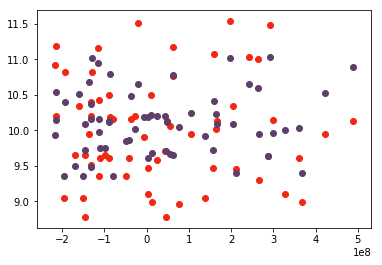

In [27]:
plt.scatter(reducer.transform(validation_set[0]), validation_set[1], c = "#F22613")
plt.scatter(reducer.transform(validation_set[0]), tree.predict(validation_set[0]), c = "#5D3F6A")